# Tutorial: Squirrels in the M&M Factory! 

##  Learning Objectives
By the end of this tutorial, students will:

* Understand the multinomial distribution for modeling categorical counts.
* Use a Dirichlet prior to encode beliefs about the color proportions.
* Compute the analytic posterior using conjugate prior theory.
* Write a simulator for use with simulation-based inference
* Use simulation-based inference with Neural Posterior Estimation to obtain unbiased samples from the posterior, even when squirrels mess with your colour distributions!

## 1. Scenario

You're handed a pack of M&Ms and asked to estimate the proportion of each color in the population of all M&Ms. This is an extension to the exercise we did earlier this week, where we just looked at blue M&Ms versus the rest.

## Imports

In [2]:
# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# Basic numerical and plotting tools
import numpy as np
import pandas as pd

# PyTorch and Pyro for probabilistic programming
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

# ArviZ for visualization and diagnostics of posterior samples
import arviz as az

# SBI package for simulation-based inference
from sbi.analysis import pairplot
from sbi.inference import NPE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import process_prior
import sbi

## 2. Collect Some Data

Example data from counting M&M colors, from earlier this week:


In [3]:
colors = [f"red", f"green", f"blue",f"yellow", f"orange", f"brown"]

## ADD YOUR OBSERVED COUNTS BELOW
red = 61	
orange = 64	
yellow = 67	
green = 65	
blue = 79	
brown = 56

observed_counts = torch.tensor([red, green, blue, yellow, orange, brown], dtype=torch.float32)
total_count = int(observed_counts.sum())

## 3. Model Assumptions

We assume that the counts for different colours follow a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution):
$$
x \sim \mathrm{Multinomial}(n, \theta)
$$

The multinomial distribution is the multi-dimensional extension to the binomial distribution. Where before we had two possible outcomes (blue and not blue), we now have $k$ outcomes. Here, $\theta = (q_1, ..., q_k)$ is now a vector describing the intrinsic fraction of each colour, for all colours, so it's a vector of length $k$. 
The multinomial distribution is defined as:

$$ 
p(x_1, ..., x_k | q_1, ..., q_k, n) = \frac{n!}{x_1! ... x_k!}q_1^{x_1} ... q_k^{x_k}
$$ 

If we want to compute our probabilities analytically, we can use the conjugate prior for the multinomial distribution, which is a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Conveniently, the Dirichlet distribution is the multivariate version of the beta-distribution, which we met earlier this week!

$$
\theta \sim \mathrm{Dirichlet}(\alpha)
$$

The Dirichlet distribution has parameters $\alpha$, and just like with the beta-distribution, we need to pick values for these. Here, we choose a non-informative prior, for which $\alpha=1$

In [4]:
alpha_prior = torch.ones(len(colors))  # Non-informative prior

# 4. Analytic Posterior 

For the analytical case, we know (or can calculate, you're encouraged to try this at home!) that the resulting posterior of the multinomial likelihood and Dirichlet prior will also be a Dirichlet distribution:

$$
\theta | x \sim \mathrm{Dirichlet}(\alpha + x)
$$ 

Here, $x$ is the vector of measured M&M counts. 

### Compute Posterior Parameters and Draw Samples

Now let's compute the posterior. Use `torch.distributions.Dirichlet()` to sample 1000 times from the Dirichlet posterior:

In [5]:
# Compute posterior parameters, using the prior we defined above and the observed M&M counts
alpha_posterior = alpha_prior + observed_counts

# Draw samples from the posterior:
posterior_analytic_samples = torch.distributions.Dirichlet(alpha_posterior).sample((1000,))

### Visualize the Analytic Posterior

What do our posteriors look like?

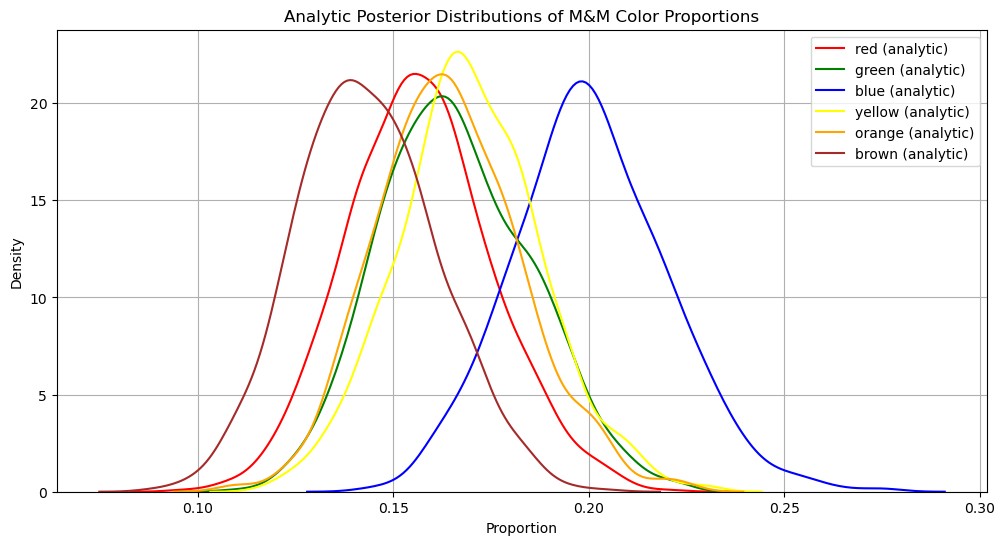

In [6]:
plt.figure(figsize=(12, 6))
for i, color in enumerate(colors):
    sns.kdeplot(posterior_analytic_samples[:, i], label=f"{color} (analytic)", color=color)
plt.title("Analytic Posterior Distributions of M&M Color Proportions")
plt.xlabel("Proportion")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# Part 2: Modeling M&M Selection Bias with Simulation-Based Inference (SBI)

Let's model the true M&M color proportions when the observed data is biased due to preferential removal of orange and brown M&Ms (due to squirrels in the factory!).


## Simulate Biased Observations

We'll start with known "true" color proportions and simulate M&M draws. Then, we'll bias the data by removing a fraction of orange and brown M&Ms.

We're going to simulate data so that we can check how close our posteriors are to the true value. Since we don't know the true underlying colour distribution of our sample above, that would make it harder to validate whether our model is working:


In [7]:
# set seed for reproducibility
torch.manual_seed(0)

# number of colours
num_colors = len(colors)
true_probs = torch.tensor([0.25, 0.05, 0.20, 0.15, 0.18, 0.17])  # ground truth

# Simulate true counts
total_mms = int(total_count)
true_counts = torch.distributions.Multinomial(total_mms, probs=true_probs).sample()

# Simulate bias: remove 50% of orange and 80% of brown M&Ms
bias = torch.ones(num_colors)
bias[colors.index("orange")] = 0.5
bias[colors.index("brown")] = 0.2

# true parameters of the model: the true probabilities for each color, and the two biases
true_theta_and_bias = torch.hstack([true_probs, torch.tensor([bias[colors.index("orange")], bias[colors.index("brown")]])])

# number of model parameters
nparams = len(true_theta_and_bias)

biased_counts = torch.floor(true_counts * bias).int()

print("True counts:    ", true_counts.int().tolist())
print("Biased counts:  ", biased_counts.tolist())

True counts:     [96, 22, 83, 64, 69, 58]
Biased counts:   [96, 22, 83, 64, 34, 11]


## Problem: We can't use the multinomial distribution as a likelihood!

Because the squirrels stole a random fraction of our M&Ms, we no longer have an analytic likelihood. What happens if we compute the posterior of the biased counts? 
Let's find out:

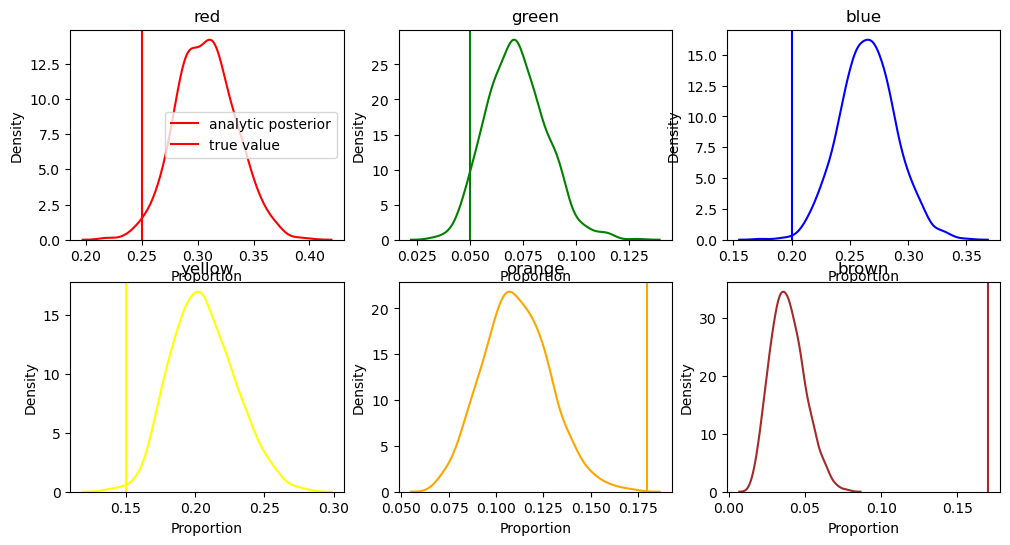

In [8]:
# the alphas for the analytical Dirichlet posterior
alpha_posterior_new = alpha_prior + biased_counts

# Draw samples from the posterior:
posterior_analytic_samples = torch.distributions.Dirichlet(alpha_posterior_new).sample((1000,))

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = np.hstack(axes)

for i, color in enumerate(colors):
    sns.kdeplot(posterior_analytic_samples[:, i], label=f"analytic posterior", color=color, ax=axes[i])
    axes[i].axvline(true_probs[i], color=color, label="true value")
    axes[i].set_title(color)
    axes[i].set_xlabel("Proportion")
    axes[i].set_ylabel("Density")

axes[0].legend()

**Question**: Why isn't it just that the brown and orange posteriors are off? Can you think about why *all* of the posteriors are off?


## Using Simulation-Based Inference to Infer the Correct Proportions

How can we infer the correct fractions produced at the factory, as if the squirrels hadn't stolen some of our M&Ms? And can we try to estimate the amount the squirrels have stolen along with the colour distribution?

For this, we'll need simulation-based inference, where we can infer unbiased posteriors even when we don't have access to a likelihood. The first component that we'll need for this is: a simulator!

This is generally a function that takes parameters as input, and then *simulates* a data set, given the parameters. 

**Exercise**:
* What are the parameters we'd like to input into our model?
* What is the expected output of the function?
* Write down the steps you'll need to take to simulate the data we want from the parameters.


While I want you to think about this conceptually, I don't want you to have to write your own simulator, so I've provided it below. Much of the code is actually linear algebra housekeeping to make PyTorch, the machine learning library powering a lot of this, work correctly. 

In [9]:
# Simulation model: maps theta to biased observed counts
def mm_simulator(theta_and_bias):
    """
    Simulate draws from a bag of M&Ms, where the brown and orange M&M counts 
    are biased. 

    Parameters
    ----------
    theta_and_bias : torch.tensor
        A tensor with 8 elements. The first six are the input color distribution,
        the last two contain the biases for the brown and orange colours.
        `theta_and_bias` can be a single set of parameters, or a tensor of multiple 
        parameter sets. 

    Returns
    -------
    samples_biased : torch.tensor
        The M&M counts for all six colours
    """
    # Beware! The total number of M&Ms in the sample is hardcoded! 
    total_mms = total_count

    # the number of different M&M colours
    num_colors = 6
    # if only one set of parameters, reshape such that the first dimension
    # is the batch dimension of size 1
    if theta_and_bias.dim() == 1:
        theta_and_bias = theta_and_bias.reshape((1, len(theta_and_bias)))

    # size of the batch of input parameters
    batch_size = theta_and_bias.shape[0]
    # split out the fraction parameters, and the bias parameters
    theta, bias = theta_and_bias.split([6,2], dim=1)

    # make a vector for each sample where the biases for brown and orange 
    # M&Ms are set by the values in `bias`, and the biases for the other 
    # colours is 1 (no bias)
    bias_all = torch.ones(batch_size, 6)
    bias_all[:,4] = bias[:,0]
    bias_all[:,5] = bias[:,1]

    # draw from multinomial
    samples = torch.distributions.Multinomial(total_mms, probs=theta).sample()
    # remove M&Ms based on bias
    samples_biased =  samples * bias_all  # apply bias (element-wise)
    
    # return floor of the biased samples, so that we only return whole M&Ms
    # For simplification, we're not counting M&Ms that the squirrels only gnawed at 
    # but left behind
    return samples_biased.floor()

Let's try it out and simulate some data. 

First, define a colour distribution in the `theta` variable, and then two bias values in `bias`. Note that the values in `theta` must sum up to one! 

In [10]:
theta = torch.tensor([0.2, 0.3, 0.1, 0.25, 0.05, 0.1])
bias = torch.tensor([0.5, 0.2])

# stack both into a single vector
theta_and_bias = torch.hstack([theta, bias])

In [11]:

samples_biased = mm_simulator(theta_and_bias)
print(samples_biased)

tensor([[ 72., 116.,  35., 105.,   9.,   9.]])


What do you observe? Are the last two values (the orange and brown M&M counts, respectively) what you expect, given your inputs?

### Inference with the Simulator
Now we can set up our inference. For this, we'll be using a library called [`sbi`](), which provides a convenient implementation to many state-of-the-art approaches to simulation-based inference. Note, however, that the library is under active development, and is sometimes developed faster than the tutorials can keep up with it, so occasionally you might run into bugs and outdated tutorials.

As with regular Bayesian inference, we first need to set up some priors.
We will keep our Dirichlet prior for the colour distribution, and we'll define uniform priors for the two biases, between zero and one (where 1 means no M&Ms have been taken by squirrels, and 0  means all M&Ms have been taken by squirrels).

As before, I've left you the code below, so that you don't have to dig through the documentation to figure this out yourselves. Note that this would be *much* easier if we were using only simple priors (e.g. all uniform) and didn't insist on the Dirichlet prior (which imposes some restrictions on the code below). 

In [12]:
from sbi.utils import MultipleIndependent

prior = MultipleIndependent(
    [
        torch.distributions.Dirichlet(alpha_prior), # prior for the colour distribution
        sbi.utils.torchutils.BoxUniform(torch.zeros(2), torch.ones(2)) # prior for the biases
    ],
    validate_args=False,
)


Today, we'll work with Neural Posterior Estimation, where we train a Normalizing Flow to approximate the posterior probability density, given pairs of training data $(\theta_i, \mathbf{y}_i)$, where $\theta_i$ is the $i$th set of parameters out of $N$ training samples, and $\mathbf{y}_i$ is the corresponding simulated set of counts. 

We will draw 5000 sets of parameters from the prior we've defined above, which ensures that the training data covers all of parameter space. We *could* simulate as a grid, but it turns out grids are very inefficient in high dimensions, and if you really have to do this in more than $\sim 10$ dimensions or so, you're better off thinking of smarter methods to sample the prior (e.g. Latin Hypercube Sampling). But that's a different topic.

Let's simulate training data:

In [13]:
# set number of simulations
num_simulations = 5000

# sample from prior
prior_samples = prior.sample((num_simulations,))

# simulate data sets from prior samples
x_simulated_biased = mm_simulator(prior_samples)

We need to put the prior into a form that can be used by SBI. Thankfully, the package has a helper function for us:

In [14]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)

Here's where we now train the normalizing flow. We'll use Neural Posterior Estimation, which uses Normalizing Flows to estimate the entire posterior. Note that there strictly isn't *one* Normalizing Flow, the term describes a whole class of different models. We use the default type of normalizing flow used for NPE in `sbi`, called a Masked Autoregressive Flow (MAF). If you'd like to know more about what a MAF is, how it works, what parameters there are for you to tweak, and what other options you have for Normalizing Flows, I'd encourage you to take a look at [Papamakarios et al (2021)](). 

The three lines below set up that neural network architecture and train it. The SBI package abstracts away an enormous amount of machine learning for this, but don't be fooled: knowledge of machine learning and how neural networks work is really important to understanding SBI, and especially figuring out when and how things go wrong! Don't blindly apply it!

In [15]:
# set up the Neural Posterior Estimation Object
inference = NPE(prior=prior)

# add simulations to inference object
inference = inference.append_simulations(prior_samples, x_simulated_biased)

# train the density estimator
density_estimator = inference.train()

 Neural network successfully converged after 118 epochs.

Congratulations! You've trained a fairly complicated neural network! Hopefully it should have been reasonably fast, too.

As you can see, `sbi` tells us that the neural network successfully converged. The Normalizing Flow has *many* parameters (the weights of the neural network), which are optimized during the training process using a class of optimization algorithms called Stochastic Gradient Descent. If the network doesn't converge, likely something is wrong, and you'll need to go bug hunting (this, for example, is where knowledge of how machine learning and neural networks work is invaluable for making SBI work reliably and robustly). 

As with Markov Chain Monte Carlo or other estimators of the posterior, we can now extract samples for an observation, and plot our posteriors. We're going to use the set of "observations" we simulated at the start of the notebook and put into the array `biased_counts`. 

Note that for interal consistency reasons (it's that PyTorch linear algebra housekeeping again!), the estimator expects to get the data as a column tensor, rather than a row tensor. So you want it's shape to be `(1, num_colors)`, rather than `(num_colors, 1)`. This is the reason for the `reshape` operation below.

In [16]:
# reshape `biased_counts` to work with the density estimator
biased_counts_column = biased_counts.reshape((1,num_colors))

# draw posterior samples from the Normalizing Flow, conditioning on the "data" in `biased_counts_column
samples = density_estimator.sample((1000,), condition=biased_counts_column).detach()
# the `detach()` method is a PyTorch thing that, if run on the GPU, moves the output of the 
# `sample()` method back onto the CPU

# remove batch dimension, again, PyTorch housekeeping!
samples = samples.squeeze(dim=1)

`sbi` has some limited analysis functionality. I believe it is also possible to transfer results from `sbi` to an `arviz`-compatible format, which is a library that gives you *many* more options for visualization and posterior summary.

For now, let's make a corner plot of the samples we've drawn, and also include the *true* values for the colour distribution and the biases we've used to simulate our observation:

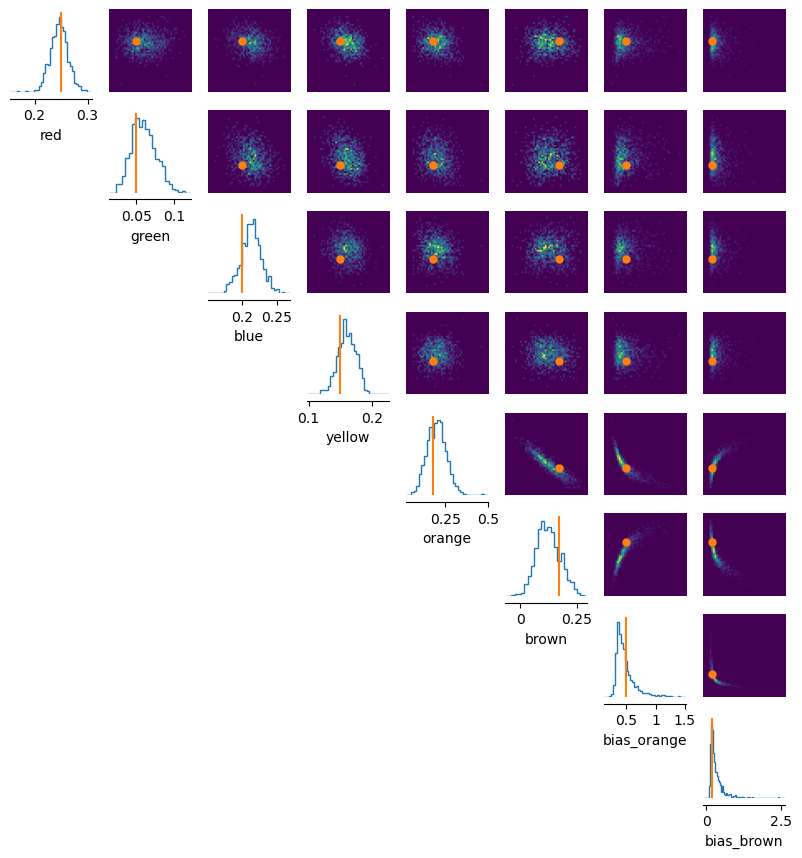

In [17]:
# define labels for the plotting
labels = list(np.hstack([colors, [f"bias_orange", f"bias_brown"]], dtype=str))

# make a corner plot (also known as a pairplot), overplot true values used to generate the data
sbi.analysis.pairplot(samples, points=true_theta_and_bias.reshape((1, nparams)), labels=labels);

**Exercise**:
* Is our inference good? How could we tell?
* Repeat the analysis above with different sizes of training data sets: try it with ten training examples, with 100, and with 10000 (and if you can, with more, though training will slow down quite a lot). Do the posteriors change? How? How many training examples do you need to trust that the posteriors come out right?

## Validating SBI Results for Science.

One key issue with neural networks is that they're very difficult to interpret: we don't know what happens inside of them, and so it's hard to understand *why* a neural network produces a certain output. This, in turn, makes it hard to understand whether the posteriors we get out are robust and trustworthy. 

This then makes it especially important to validate our SBI results. Below, I'll give you some suggestions and exercises that you can use to validate SBIu results in practice.

### Step 1: Pick a toy problem where you *can* compute a likelihood

Before you go full SBI on your problem, you might want to consider exploring a problem where you *can* compute a likelihood, and compare the SBI results to the results from the posteriors you get with a likelihood. 

This is especially important if your problem requires an embedding net, where you need to train both a data summarizing network and the normalizing flow. This can be hard to get to work correctly, so having a problem where you can figure out what's happening is super useful. 

**Exercise**
* write a simple simulator *without* the bias, just a model that draws from the multi-nomial distribution we'd expect without squirrel infestation, and returns the draws
* train a normalizing flow with that simulator
* compute the posterior for different true values of the color distributions, and compare to the the analytical posteriors. What do you find?
* Vary the number of total M&Ms in your sample: do the results change?

**Important**: Make sure you name your simulator and density estimator differently, so that we can keep using the one above later!

**Hint**: For this, you can easily define your prior in one line: 
```
prior = torch.distributions.Dirichlet(alpha_prior)
```

In [90]:
# Simulation model: maps theta to biased observed counts
def unbiased_mm_simulator(theta):
    """
    Simulate draws from a bag of M&Ms, where the brown and orange M&M counts 
    are biased. 

    Parameters
    ----------
    theta : torch.tensor
        A tensor with 6 elements, for the input color distribution,
        `theta` can be a single set of parameters, or a tensor of multiple 
        parameter sets. 

    Returns
    -------
    samples_biased : torch.tensor
        The M&M counts for all six colours
    """
    ######################
    # ADD YOUR CODE HERE #
    ######################
    return samples

Now let's define the prior:

Simulate data:

Let's simulate an observation, using our simulator, and let's also define the analytical posterior using the Dirichlet distribution to compare:

In [107]:
# draw a sample from the unbiased simulator
unbiased_y = unbiased_mm_simulator(true_probs)
print(unbiased_y)

# Compute posterior parameters, using the prior we defined above and the observed M&M counts
alpha_posterior_unbiased = alpha_prior + unbiased_y

# Draw samples from the analyticalposterior:
posterior_analytic_samples_unbiased = torch.distributions.Dirichlet(alpha_posterior_unbiased).sample((10000,))

tensor([[50., 11., 41., 28., 27., 43.]])


Now draw 1000 posterior samples from your trained SBI model for the `unbiased_y` data set you simulated:

Now let's plot the analytic posterior density along with the samples from the Normalizing Flow:

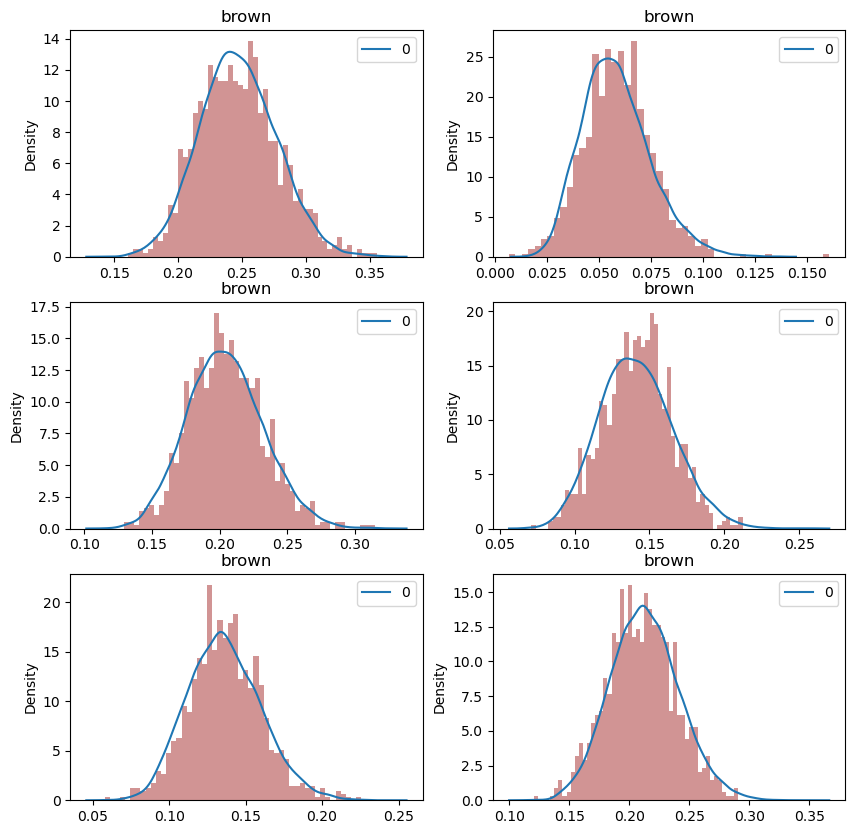

In [110]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes = np.hstack(axes)

for i, c in enumerate(colors):
    sns.kdeplot(posterior_analytic_samples_unbiased[:, :, i], label=f"{color} (analytic)", color=color, ax=axes[i])
    axes[i].hist(samples_unbiased[:,i], bins=50, histtype="stepfilled", color=color, alpha=0.5, density=True)
    axes[i].set_title(color)

### Step 2: Implement the actual simulator, then explore posterior space

Let's go back to our original simulator, and the biased samples. Train the density estimator with however many simulations you decided earlier are reasonable, then explore parameter space:

**Exercise**
* generate fake data for different combinations of true parameters, and explore the posterior for each simulated data set. What happens when the biases are very large, or very small? What happens when the fractions of colours are very unequal?

### Step 3: A more formal analysis of the SBI performance

There are a bunch of different ways you can analyse the performace of a density estimator, but a popular one are probability-probability plots. These describe how often the true parameters are within a certain credible interval of the posterior. To calculate them, you need *many* simulated data sets and their corresponding posterior densities, which is why amortized SBI is often really useful in practice!

Below is a function that calculates the pp-plot for each parameter, and then plots it as a curve:

### PP Plots

In [128]:
def compute_and_plot_pp(true_params, posterior_samples, n_bins=20, labels=None):
    """
    Compute and plot marginal PP plots for each parameter dimension.

    Parameters
    ----------
    true_params : torch.array of shape (N, D)
        The D-Dimensional vectors of true parameters for each of the N simulated data sets
        for which we've obtained posteriors

    posterior_samples: torch.array of shape (N, S, D)
        For each of the simulations, we have obtained S posterior samples

    nbins : int
        The number of coverage levels (e.g. 20 for 5% increments)

    labels : array of str
        The labels for each dimension in D (here: colours)
    """
    # N is the number of simulations
    # D is the number of dimensions, i.e. the number of M&M colours
    N, D = true_params.shape

    # make sure that the posterior samples have the right shape
    # We don't have an independent way to assess S, the number of samples 
    # per bin
    assert posterior_samples.shape == (N, posterior_samples.shape[1], D)

    # coverage levels, in fractions of 1
    # this goes on the x-axis
    alphas = np.linspace(0, 1, n_bins + 1)

    # make figure
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # for perfect coverage, we'd expect to be close to a diagonal,
    # so let's plot one!
    ax.plot(alphas, alphas, "--", label="Ideal")

    # if the user doesn't supply labels, make some
    if labels is None:
        labels = [rf"$x_{d}$" for d in range(D)]

    # iterate over D
    for d in range(D):
        # Compute rank statistics per simulation for parameter d
        true_vals = true_params[:, d]
        samples_d = posterior_samples[:, :, d]

        # Sort each posterior sample set
        sorted_samples, indices = torch.sort(samples_d, axis=1)

        # Compute empirical coverage for each alpha
        coverage = []
        for alpha in alphas:
            lower_idx = ((1.0 - alpha) / 2.0 * samples_d.shape[1]).astype(int)
            upper_idx = ((1.0 + alpha) / 2.0 * samples_d.shape[1]).astype(int)
            lower = sorted_samples[:, lower_idx]
            upper = sorted_samples[:, np.minimum(upper_idx, samples_d.shape[1]-1)]
            covered = (true_vals >= lower) & (true_vals <= upper)
            coverage.append(torch.sum(covered)/len(lower))

        # Plot PP plot for this dimension
        ax.plot(alphas, coverage, label=labels[d], lw=2)
        ax.set_xlabel("Nominal Credible Level")
        ax.set_ylabel("Empirical Coverage")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

Now we can try it out!

First run the inference 500 times, drawing from the prior:

In [125]:
nsamples = 1000
nsims = 500
ndim = 8

# sample from prior
pp_prior_samples = prior.sample((nsims,))

# simulate data sets from prior samples
pp_x_simulated_biased = mm_simulator(pp_prior_samples)

Now we can get posterior samples for all of these prior samples:

In [126]:
pp_samples = torch.zeros((nsims, nsamples, ndim))
for i, px in enumerate(pp_x_simulated_biased):
    samples = density_estimator.sample((nsamples,), condition=px.reshape((1,num_colors))).detach()
    pp_samples[i,:,:] = samples.squeeze(dim=1)

Let's run it!

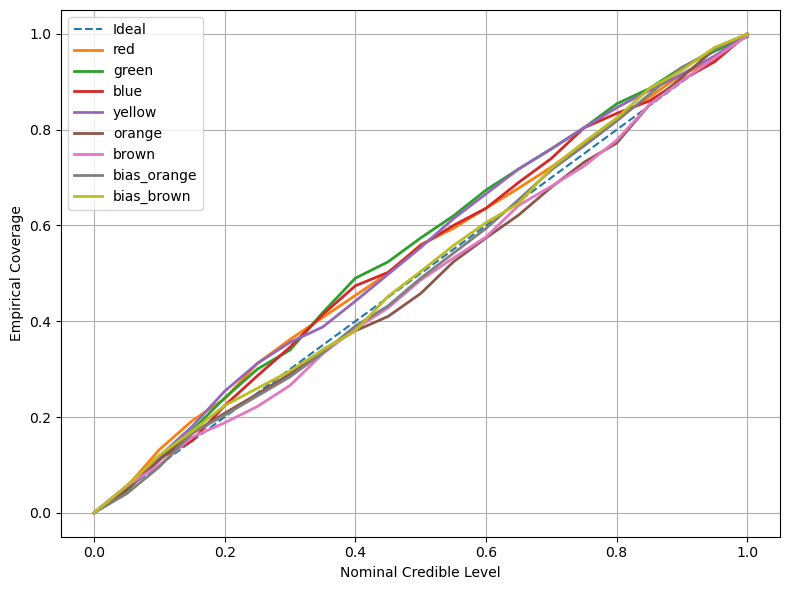

In [129]:
compute_and_plot_pp(pp_prior_samples, pp_samples, labels=labels)